# Final Report Capstone Project

## Battle of Neighbourhoods - Finding New Place to Stay at Toronto, Canada

## Introduction

Finding new place to stay is a hard thing to do. Several parameters need to be considered to find the best place to stay at, for example: house prices, crime rate, population density, and nearby venues. House price is important because usually people who want to find a new house have certain budgets and they want to buy (or rent) a new house within their budgets. Even if they have huge budgets, they would want to find the best place with minimum price. House price may be affected by several variables such as crime rate, population density, location, the number of floors, house materials, etc. \
\
Besides the house price, they also need to find place with low crime rate, low population density or high population density depending on preference, and nearby venues that fit their daily activities. The parameters mentioned above can be correlated to each other. \
\
In this project, I use Toronto as the object. Toronto's Neighbourhoods are clustered based on the parameters above and the best neighbourhoods will be chosen. Although there are more parameters that need to be considered, for the sake of simplicity and data availability, I limit the parameters considered to house prices, crime rate, population density, and nearby venues only. Moreover, the final decision is decided based on preferences of individuals and more research should be made. If possible, visiting the neighbourhood in person will be better. Therefore, the results of this project can only be used to narrow the options of neighbourhood in Toronto to stay at.

## Business Problem

There are around 140 neighbourhoods in Toronto. Choosing place to stay in Toronto can be hard because of this. Therefore, reducing the options of neighbourhood is important not only for the potential buyer (person who wants to relocate to Toronto), but also for the real estate company. For the potential buyers who have budgets and other preferences, reducing the number of neighbourhood options is important because it helps them to reduce the time and effort needed to look into the neighbourhood one by one. On the other hand, for the real estate companies, reducing the number of neighbourhood options is important because they can focus to promote certain neighbourhoods to their potential buyers (or renters).

## Data

Several parameters that are used in this study to narrow down the Toronto's neighbourhood options are:
1. House price
2. Crime rate
3. Population density
4. Nearby venues

House price is affected by many parameters such as locations, number of bedrooms, conditions, etc. However, in this project, I only consider the average house price in each neighbourhood. The source for this data is https://www.zolo.ca/toronto-real-estate/neighbourhoods. This website provides average house price, percentage of house sold after 10 days of listing, the number of active listings, and percentage of house sold after the potential buyers asked about the unit in each neighbourhood. Based on the source, the data is based on the last 28 days data. \
\
The source of crime rate and population density data is Toronto Public Service Public Safety Data Portal (https://opendata.arcgis.com/datasets/af500b5abb7240399853b35a2362d0c0_0.csv?outSR=%7B%22latestWkid%22%3A26717%2C%22wkid%22%3A26717%7D). This source provides the number of crimes occured in each neighbourhood every year from 2014-2018 complete with the types, the number of population and area for each neighbourhood. The population density can be calculated using number of population divided by the neighbourhood area. \
\
Nearby venues can be determined using Foursquare API (https://foursquare.com/). Foursquare API provides many data including venue name, type, photos, tips, and many others.

### Code for handling data

#### Load Libraries

In [1]:
# Importing libraries
import pandas as pd #to work with dataframes
import numpy as np #to work with arrays
import matplotlib.pyplot as plt #to work with plot
from geopy.geocoders import Nominatim #to call the location data
from sklearn.cluster import KMeans #to conduct k-means clustering
from sklearn.preprocessing import MinMaxScaler #to normalize the data
import matplotlib.cm as cm # Matplotlib and associated plotting modules
import matplotlib.colors as colors # Matplotlib and associated plotting modules

#### Load and clean data

In [2]:
#Loading house price data
house_price=pd.read_html('https://github.com/setiawantm/Coursera_Capstone/blob/master/toronto_house_price.csv')[0]
house_price.drop(columns=['Unnamed: 0', 'Sold under 10d', 'Sold above asking', 'Active listings'], inplace=True)
house_price.rename(columns = {'Neighbourhoods':'Neighbourhood'}, inplace = True) 

#Loading crime rate data
crime_rate=pd.read_html('https://github.com/setiawantm/Coursera_Capstone/blob/master/Neighbourhood_Crime_Rates_Boundary_File_.csv')[0]

#Cleaning up the crime rate dataframe and getting the total crime in 2018
crime_rate.drop(columns=['Unnamed: 0', 'OBJECTID', 'Neighbourhood_Crime_Rates_Neigh', 'Neighbourhood_Crime_Rates_Hood_', 'Hood_ID'], inplace=True)
crime_rate.drop(crime_rate.filter(like='AVG',axis=1).columns,axis=1, inplace=True)
crime_rate.drop(crime_rate.filter(like='CHG',axis=1).columns,axis=1, inplace=True)
crime_rate.drop(crime_rate.filter(like='Rate',axis=1).columns,axis=1, inplace=True)
crime_rate2=crime_rate.filter(like='2018', axis=1)
crime_rate2.loc[:,'Total_Crime_2018'] = crime_rate2.sum(axis=1)
crime_rate.drop(crime_rate.filter(like='Assault',axis=1).columns,axis=1, inplace=True)
crime_rate.drop(crime_rate.filter(like='Auto',axis=1).columns,axis=1, inplace=True)
crime_rate.drop(crime_rate.filter(like='Homicide',axis=1).columns,axis=1, inplace=True)
crime_rate.drop(crime_rate.filter(like='BreakandEnter',axis=1).columns,axis=1, inplace=True)
crime_rate.drop(crime_rate.filter(like='Robbery',axis=1).columns,axis=1, inplace=True)
crime_rate.drop(crime_rate.filter(like='Theft',axis=1).columns,axis=1, inplace=True)
crime_rate.drop(columns=['Shape__Length'],axis=1, inplace=True)
crime_rate['Total_Crime_2018']=crime_rate2['Total_Crime_2018']

# Merging the 2 dataframes into one based on Neighbourhood
merge=pd.merge(house_price, crime_rate, on=['Neighbourhood'], how='inner')

# Creating population density by dividing the population and area
merge['density']=merge['Population']/merge['Shape__Area']
merge.head()

# Modify and remove the neighbourhood data that results in error in geocoder for Latitude and Longitude data
merge['Neighbourhood'] = merge['Neighbourhood'].str.split('-').str[0]
merge.loc[43,'Neighbourhood']='Cliffside'
merge.drop(merge.index[71], inplace=True)
merge.drop(merge.index[76], inplace=True)
merge.loc[98,'Neighbourhood']='Danforth'
merge.drop(merge.index[118], inplace=True)

/opt/conda/envs/Python36/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/opt/conda/envs/Python36/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


#### Getting Location data from Geocoder

In [3]:
latitudes = [] # Initializing the latitude array
longitudes = [] # Initializing the longitude array
i=1
for nbd in merge["Neighbourhood"] : 
    place_name = nbd + ", Toronto, Canada" # Formats the place name
    geolocator = Nominatim()
    location = geolocator.geocode(place_name)
    lat = location.latitude
    lng = location.longitude
    print(i,lat,lng)
    i=i+1
    latitudes.append(lat) # Appending to the list of latitudes
    longitudes.append(lng) # Appending to the list of longitudes

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:6: DeprecationWarning: Using Nominatim with the default "geopy/1.18.1" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.


1 43.8080383 -79.2664391
2 43.7600778 -79.5717598
3 43.6995391 -79.5563459
4 43.7689144 -79.1872905
5 43.7853531 -79.2785494
6 43.6901578 -79.4749985
7 43.8161778 -79.3145378
8 43.7833623 -79.4558358
9 43.7691966 -79.3766617
10 43.7353996 -79.370883
11 43.7457757 -79.4405557
12 43.7115939 -79.4360013
13 43.7122767 -79.4901977
14 43.7427961 -79.3699566407258
15 43.6781015 -79.409415775
16 43.799003 -79.3059669
17 43.7938863 -79.4256790230105
18 43.76389295 -79.4563669371095
19 43.6969975 -79.5218834
20 43.653963 -79.387207
21 43.7615095 -79.4109234
22 43.6649511 -79.3873955
23 43.7007782 -79.4945217
24 43.787048 -79.3337137
25 43.7246418 -79.4475031
26 43.7373876 -79.4109253
27 43.6435491 -79.5653253455361
28 43.7615095 -79.4109234
29 43.7587808 -79.5194336
30 43.7981268 -79.3829726
31 43.7926732 -79.3547219
32 43.7826012 -79.2049579
33 43.7001608 -79.5162474
34 43.6954005 -79.485495
35 43.7996637 -79.3650189
36 43.8091955 -79.2217008
37 43.6786916 -79.4834269
38 43.6935586 -79.4139023


In [5]:
# Merging the latitude and longitude data into the dataframe
merge['Latitude']=latitudes
merge['Longitude']=longitudes

merge.head()

,Neighbourhood,Average sale price,Population,Shape__Area,Total_Crime_2018,density,Latitude,Longitude
0,Agincourt North,703000,31528,7.261857e+06,513.0,0.004342,43.808038,-79.266439
1,Humber Summit,648000,14188,7.966905e+06,59.0,0.001781,43.760078,-79.571760
2,Kingsview Village,619000,14306,5.063371e+06,263.0,0.002825,43.699539,-79.556346
3,West Hill,663000,36371,9.625440e+06,139.0,0.003779,43.768914,-79.187291
4,Agincourt South,676000,28410,7.873163e+06,154.0,0.003608,43.785353,-79.278549


## Methodology

To be able to fulfil the objective of this project which is to narrow down the neighbourhood options to live at Toronto, several things need to be done with the data mentioned in previous section. The steps are:
1. Exploratory data analysis \
This step can be done by plotting the boxplot or distribution of each variables. In this project, I use the boxplot. By plotting the boxplot, we can get the information of skewness of the data, outliers, quartiles, maximum and minimum values. We can remove the outliers if necessary. We also need to look whether the variables are correlated to each other or not to determine which machine learning method to use and to possibly reduce the dimensions. This can be done by plotting scatter plots between each variable or determine the pearson coefficient and the confidence level. In this project, we will determine the correlations visually.
2. Clustering analysis I \
This step is done to find the neighbourhoods with low average house price, low crime rate, and low population density. The low average house price and low crime rate are obvious parameters. But low population density is a matter of preference. I personally prefer living at not too crowded area, so I will use low population density as one parameter to determine the cluster. For other preferences the same step can also be done with several modifications. This step can be done using k-means clustering analysis.
3. Finding the nearby venues for chosen neighbourhoods \
This step is done using the foursquare API. For the chosen neighbourhoods (from step 2), top 5 venues within 500 meters are populated and included into the dataframe.
4. Clustering analysis II \
The second clustering analysis using k-means clustering method is done to determine the clusters of neighbourhoods with similar venue types. This is done to further narrow down the neighbourhood options based on personal preferences. For example, if the potential buyer is interested in finding a place that is near restaurants, we can suggest the cluster of neighbourhoods that has restaurants as the most commonly visited venue.

### Exploratory data analysis

#### Boxplots

Based on the boxplots below for each variables, the distributions are right skewed distribution with outliers on the right side of the data. The next step of the exploratory data analysis is to plot the scatter plots of each variable to find any correlations between the variables. Because of this, outliers are removed from the data to better visualize the data in the scatter plot. Moreover, at the end of the project, we are filtering out the high price, high crime rate and high population density anyway, so removing the outliers which are located at high values of each variable helps with this objective.

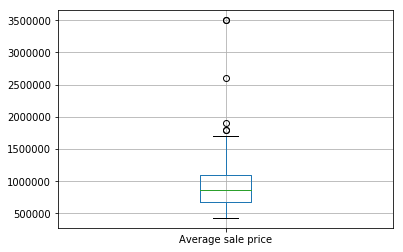

In [9]:
#Boxplot for House Price
boxplot=merge.boxplot(column=['Average sale price'])

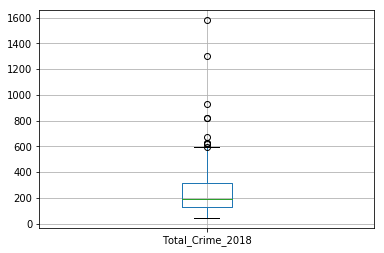

In [7]:
#Boxplot for Crime rate
boxplot=merge.boxplot(column=['Total_Crime_2018'])


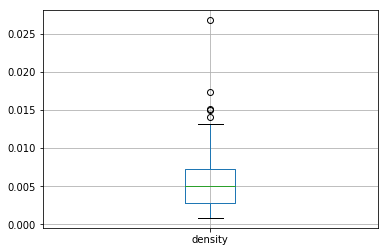

In [8]:
#Boxplot for Population density
boxplot=merge.boxplot(column=['density'])

In [10]:
# Removing the house prices outliers.
q = merge["Average sale price"].quantile(0.95)
merge=merge[merge["Average sale price"] < q]

# Removing the Total crimes outliers
p = merge["Total_Crime_2018"].quantile(0.95)
merge=merge[merge["Total_Crime_2018"] < p]

# Removing the Population Density outliers
r = merge["density"].quantile(0.95)
merge=merge[merge["density"] < r]

#### Scatter Plot

Visually, the scatter plots between the 3 variables show that there is no clear correlation between the variables. Therefore, we will use all three variables in the machine learning analysis (clustering). Clustering analysis is done as unsupervised learning because there is no clear result in the dataframe.

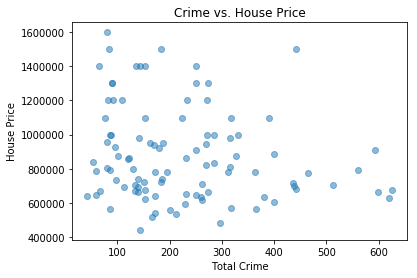

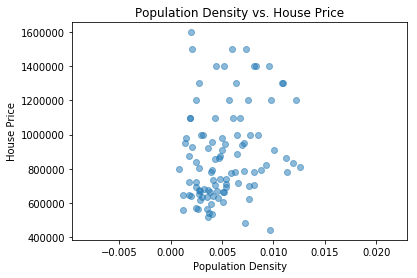

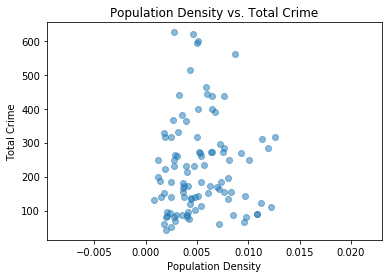

In [11]:
#Scatter plot of Total Crime vs. House Price for every Neighbourhood
plt.scatter(merge['Total_Crime_2018'], merge['Average sale price'], alpha=0.5)
plt.title('Crime vs. House Price')
plt.xlabel('Total Crime')
plt.ylabel('House Price')
plt.show()

#Scatter plot of Population Density vs. House Price for every Neighbourhood
plt.scatter(merge['density'], merge['Average sale price'], alpha=0.5)
plt.title('Population Density vs. House Price')
plt.xlabel('Population Density')
plt.ylabel('House Price')
plt.show()

#Scatter plot of Population Density vs. Total Crime for every Neighbourhood
plt.scatter(merge['density'], merge['Total_Crime_2018'], alpha=0.5)
plt.title('Population Density vs. Total Crime')
plt.xlabel('Population Density')
plt.ylabel('Total Crime')
plt.show()

### Clustering Analysis I

#### Normalize Data

The data is normalized because the scales of the variables are uncomparable. For example, the house price scale is from hundred thousands to millions, while the population densities are less than 1. Conducting machine learning analysis immediately without normalizing the data may heavily be affected by the house price variable. Therefore, normalizing the data needs to be done to make sure that the variables are on the same scale (0-1) and that all variables have same effect to the results.

In [13]:
# Normalizing data using minmaxscaler
normalized=merge
column_names_to_normalize = ['Average sale price', 'Total_Crime_2018', 'density']

x = normalized[['Average sale price', 'Total_Crime_2018', 'density']]
scaler=MinMaxScaler()
x_scaled = scaler.fit_transform(x)
normalized_temp = pd.DataFrame(x_scaled, columns=column_names_to_normalize, index = normalized.index)
normalized[column_names_to_normalize] = normalized_temp

normalized.head()

,Neighbourhood,Average sale price,Population,Shape__Area,Total_Crime_2018,density,Latitude,Longitude
0,Agincourt North,0.226057,31528,7.261857e+06,0.807560,0.298687,43.808038,-79.266439
1,Humber Summit,0.178602,14188,7.966905e+06,0.027491,0.080287,43.760078,-79.571760
2,Kingsview Village,0.153581,14306,5.063371e+06,0.378007,0.169372,43.699539,-79.556346
3,West Hill,0.191544,36371,9.625440e+06,0.164948,0.250673,43.768914,-79.187291
4,Agincourt South,0.202761,28410,7.873163e+06,0.190722,0.236159,43.785353,-79.278549


#### K-Means Clustering

K-means clustering is one of unsupervised learning where the code divides the data into k number of clusters based on their similarities. In this project, the number of clusters used is determined using trial and error. After each trial, the results are visualized. The number of clusters that will be used is 5. It is because using 5 clusters, we can fulfil our objective to determine neighbourhoods with low price, low crime rate and low population density. Using number of clusters lower or higher than 5 result in unclear cluster properties. \
\
Based on the clustering result, we will proceed with the neighbourhood cluster 2, which has low price, low crime rate, and low population density. In the scatter plots, the neighbourhoods are marked with blue color.

In [22]:
normalized.drop(columns=['Cluster Labels'], axis=1, inplace=True)

# set number of clusters
kclusters = 5

cluster = normalized.drop(columns=['Neighbourhood', 'Population', 'Shape__Area'], axis=1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(cluster)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

# add clustering labels
normalized.insert(0, 'Cluster Labels', kmeans.labels_)

In [16]:
# Function to map the colors as a list from the input list of x variables
def pltcolor(lst):
    cols=[]
    for l in lst:
        if l==0:
            cols.append('red')
        elif l==1:
            cols.append('blue')
        elif l==2:
            cols.append('green')
        elif l==3:
            cols.append('yellow')
        else:
            cols.append('black')
    return cols

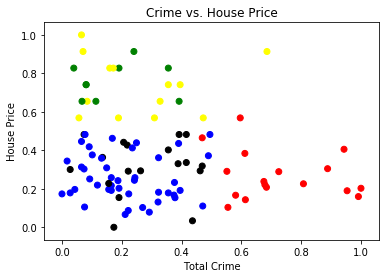

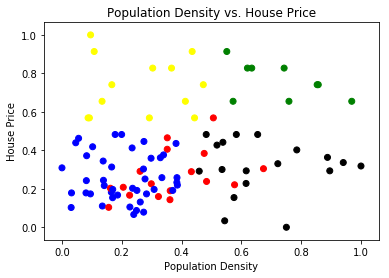

In [23]:
# Create the colors list using the function above
cols=pltcolor(normalized['Cluster Labels'])

plt.scatter(normalized['Total_Crime_2018'], normalized['Average sale price'], color=cols)
plt.title('Crime vs. House Price')
plt.xlabel('Total Crime')
plt.ylabel('House Price')
plt.show()

plt.scatter(normalized['density'], normalized['Average sale price'], color=cols)
plt.title('Population Density vs. House Price')
plt.xlabel('Population Density')
plt.ylabel('House Price')
plt.show()

### Finding the nearby venues for chosen neighbourhoods

Foursquare API is used to find nearby venues for the chosen neighbourhoods. In this project, we are using 500 meters radius from the location data of each neighbourhood. After that, the top 5 venues are populated and included into the dataframe.

In [25]:
# Importing Libraries
import json # library to handle JSON files
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    altair-4.0.0               |             py_0         606 KB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    branca-0.3.1               |             py_0          25 KB  conda-forge
    openssl-1.1.1d             |       h516909a_0         2.1 MB  conda-forge
    ca-certificates-2019.11.28 |       hecc5488_0         145 KB  conda-forge
    certifi-2019.11.28         |           py36_0         149 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         3.1 MB

The following NEW packages will be 

In [26]:
#Foursquare API client information

CLIENT_ID = 'YJUVO2UXKQMH4NEUVULGD1W0L5HU5Z1DH0XS4SY0G5ZMNLUT' # your Foursquare ID
CLIENT_SECRET = 'BGDRVMW32J4ECWZXDSS0AZWZFVGPAVDQOJNM5CNG13ZJSF5F' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version


LIMIT=100
radius = 500

In [27]:
#Function to get venues nearby
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [29]:
df=normalized[(normalized['Cluster Labels']==1)]
#Getting all the venues nearby Toronto Neighborhoods
toronto_venues = getNearbyVenues(names=df['Neighbourhood'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude']
                                  )

#Grouping the venue based on Neighbourhood
toronto_venues.groupby('Neighborhood').count()

# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighbourhood'] = toronto_venues['Neighborhood']

# move neighbourhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

Humber Summit
Kingsview Village
West Hill
Agincourt South
Keelesdale
Steeles
Bayview Village
Banbury
L'Amoreaux
Newtonbrook West
Elms
Brookhaven
Yorkdale
Etobicoke West Mall
York University Heights
Bayview Woods
Morningside
Weston
Hillcrest Village
Malvern
West Humber
Beechborough
Bendale
Cliffside
Briar Hill
Clairlea
Dorset Park
Downsview
Eglinton East
Eringate
Henry Farm
High Park
Highland Creek
Junction Area
Mimico
Mount Dennis
New Toronto
O'Connor
Parkwoods
Rustic
South Riverdale
Victoria Village
Woburn


In [32]:
#Grouping the neigborhood and finding top 5 venues in the neighborhood
toronto_grouped = toronto_onehot.groupby('Neighbourhood').mean().reset_index()

num_top_venues = 5

for hood in toronto_grouped['Neighbourhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighbourhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Agincourt South----
                    venue  freq
0      Chinese Restaurant  0.21
1     Rental Car Location  0.14
2  Peking Duck Restaurant  0.07
3   Vietnamese Restaurant  0.07
4       Korean Restaurant  0.07


----Banbury----
                  venue  freq
0                  Park  0.50
1          Tennis Court  0.25
2           Auto Garage  0.25
3     Accessories Store  0.00
4  Outdoor Supply Store  0.00


----Bayview Village----
                  venue  freq
0        Breakfast Spot  0.08
1                  Bank  0.08
2  Fast Food Restaurant  0.08
3    Persian Restaurant  0.08
4        Sandwich Place  0.08


----Bayview Woods----
               venue  freq
0            Dog Run   1.0
1  Accessories Store   0.0
2    Paintball Field   0.0
3             Museum   0.0
4        Music Venue   0.0


----Beechborough----
                    venue  freq
0  Furniture / Home Store  0.33
1            Dessert Shop  0.11
2             Auto Garage  0.11
3          Discount Store  0.11
4       Con

In [30]:
#Function to sort venues in descending order
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [41]:
#Create new dataframe with top 5 venues
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighbourhoods_venues_sorted = pd.DataFrame(columns=columns)
neighbourhoods_venues_sorted['Neighbourhood'] = toronto_grouped['Neighbourhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighbourhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighbourhoods_venues_sorted.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Agincourt South,Chinese Restaurant,Rental Car Location,Coffee Shop,Asian Restaurant,Hong Kong Restaurant
1,Banbury,Park,Auto Garage,Tennis Court,Falafel Restaurant,Food & Drink Shop
2,Bayview Village,Pizza Place,Bank,Outdoor Supply Store,Clothing Store,Sandwich Place
3,Bayview Woods,Dog Run,Yoga Studio,Farmers Market,Food Court,Food & Drink Shop
4,Beechborough,Furniture / Home Store,Dessert Shop,Italian Restaurant,Discount Store,Auto Garage


### Clustering Analysis II

The second K-means clustering analysis is done to cluster the neighbourhoods with similar top 10 nearby venues. The number of clusters are also determined by trial and error. After each trial of number of clusters, cluster exploratory is done by observing each cluster. Based on the cluster exploratory, I determine to use 5 clusters.

In [42]:
# set number of clusters
kclusters = 5

toronto_grouped_clustering = toronto_grouped.drop('Neighbourhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

# add clustering labels
neighbourhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = df.drop(columns=['Cluster Labels'], axis=1)

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighbourhoods_venues_sorted.set_index('Neighbourhood'), on='Neighbourhood')

# drop nan row i.e. "M9A"
toronto_merged_clean=toronto_merged.dropna()

### Cluster Exploratory

#### First Cluster
First cluster has park as the most common venue. These neighbourhoods are suitable for people who enjoy spending time outside, especially when the weather is nice.

In [52]:
# First Cluster
toronto_merged_clean.loc[toronto_merged_clean['Cluster Labels'] == 0, toronto_merged_clean.columns[[0] + list(range(5, toronto_merged_clean.shape[1]))]]

,Neighbourhood,density,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
2,Kingsview Village,0.169372,43.699539,-79.556346,0,Park,Yoga Studio,Falafel Restaurant,Food & Drink Shop,Flea Market
13,Banbury,0.274121,43.742796,-79.369957,0,Park,Auto Garage,Tennis Court,Falafel Restaurant,Food & Drink Shop
61,Eringate,0.000000,43.662273,-79.576516,0,Park,Yoga Studio,Falafel Restaurant,Food & Drink Shop,Flea Market
67,Henry Farm,0.240083,43.769509,-79.354296,0,Park,Tennis Court,Yoga Studio,Falafel Restaurant,Food & Drink Shop


#### Second Cluster
Second cluster has pizza place and fast food restaurants as the most common venues. Several neighbourhoods that have venues other than pizza place or fast food restaurants in the most common venue, have fast food restaurants (pizza, fried chicken, sandwich, falafel, etc.) in their top 5 most common venues. This cluster is suitable for busy people who need to grab fast foods frequently.

In [51]:
# Second Cluster
toronto_merged_clean.loc[toronto_merged_clean['Cluster Labels'] == 1, toronto_merged_clean.columns[[0] + list(range(5, toronto_merged_clean.shape[1]))]]

,Neighbourhood,density,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
3,West Hill,0.250673,43.768914,-79.187291,1,Pizza Place,Breakfast Spot,Fast Food Restaurant,Coffee Shop,Smoothie Shop
5,Keelesdale,0.384223,43.690158,-79.474998,1,Museum,Discount Store,Sandwich Place,Yoga Studio,Falafel Restaurant
8,Bayview Village,0.334206,43.769197,-79.376662,1,Pizza Place,Bank,Outdoor Supply Store,Clothing Store,Sandwich Place
18,Elms,0.030735,43.696998,-79.521883,1,Pizza Place,Park,Skating Rink,Grocery Store,Soccer Field
22,Brookhaven,0.385946,43.700778,-79.494522,1,Pizza Place,Vietnamese Restaurant,Grocery Store,Supermarket,Electronics Store
28,York University Heights,0.165104,43.758781,-79.519434,1,Pizza Place,Discount Store,Fast Food Restaurant,Gas Station,Coffee Shop
31,Morningside,0.227095,43.782601,-79.204958,1,Park,Coffee Shop,Sandwich Place,Supermarket,Pharmacy
32,Weston,0.308177,43.700161,-79.516247,1,Coffee Shop,Train Station,Pharmacy,Fried Chicken Joint,Convenience Store
34,Hillcrest Village,0.166166,43.799664,-79.365019,1,Pharmacy,Pool,Shopping Mall,Park,Sandwich Place
35,Malvern,0.273170,43.809196,-79.221701,1,Pizza Place,Gym / Fitness Center,Fast Food Restaurant,Pharmacy,Grocery Store


#### Third Cluster
Third cluster contains the neighbourhoods that have non-American restaurant (chinese, korean, mexican, asian, italian, etc.) as the top 5 most common venues. These neighbourhoods are suitable for people who loves non-american foods and frequently order them at restaurants.

In [53]:
# Third Cluster
toronto_merged_clean.loc[toronto_merged_clean['Cluster Labels'] == 2, toronto_merged_clean.columns[[0] + list(range(5, toronto_merged_clean.shape[1]))]]

,Neighbourhood,density,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
1,Humber Summit,0.080287,43.760078,-79.571760,2,Pharmacy,Park,Bakery,Empanada Restaurant,Gift Shop
4,Agincourt South,0.236159,43.785353,-79.278549,2,Chinese Restaurant,Rental Car Location,Coffee Shop,Asian Restaurant,Hong Kong Restaurant
15,L'Amoreaux,0.282766,43.799003,-79.305967,2,Chinese Restaurant,Coffee Shop,Athletics & Sports,Bus Stop,Yoga Studio
16,Newtonbrook West,0.199539,43.793886,-79.425679,2,Korean Restaurant,Coffee Shop,Vietnamese Restaurant,Hardware Store,Middle Eastern Restaurant
24,Yorkdale,0.185932,43.724642,-79.447503,2,Clothing Store,Coffee Shop,Cosmetics Shop,Fast Food Restaurant,Toy / Game Store
26,Etobicoke West Mall,0.135088,43.643549,-79.565325,2,Hotel,Coffee Shop,Café,Bank,Farmers Market
36,West Humber,0.031865,43.678692,-79.483427,2,Furniture / Home Store,Seafood Restaurant,Park,Locksmith,Yoga Studio
41,Beechborough,0.045986,43.695030,-79.471683,2,Furniture / Home Store,Dessert Shop,Italian Restaurant,Discount Store,Auto Garage
54,Dorset Park,0.249233,43.752847,-79.282067,2,Indian Restaurant,Gaming Cafe,Asian Restaurant,Bakery,Beer Store
56,Downsview,0.081515,43.749299,-79.462248,2,Coffee Shop,Metro Station,Gym Pool,Gym / Fitness Center,Playground


#### Fourth Cluster
The fourth cluster contains only one neighbourhood. This neighbourhood contains playground as the most common venue. This neighbourhood is suitable for family with kids.

In [54]:
# Fourth Cluster
toronto_merged_clean.loc[toronto_merged_clean['Cluster Labels'] == 3, toronto_merged_clean.columns[[0] + list(range(5, toronto_merged_clean.shape[1]))]]

,Neighbourhood,density,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
6,Steeles,0.384632,43.816178,-79.314538,3,Playground,Deli / Bodega,Food & Drink Shop,Flea Market,Fish Market


#### Fifth Cluster
The fifth cluster also contains only one neighbourhood. This neighbourhood contains dog run as the most commong venue. This neighbourhood is suitable for people with dogs.

In [55]:
# Fifth Cluster
toronto_merged_clean.loc[toronto_merged_clean['Cluster Labels'] == 4, toronto_merged_clean.columns[[0] + list(range(5, toronto_merged_clean.shape[1]))]]

,Neighbourhood,density,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
29,Bayview Woods,0.102567,43.798127,-79.382973,4,Dog Run,Yoga Studio,Farmers Market,Food Court,Food & Drink Shop


## Result and Discussion

### Visualizing the Neighbourhood Clusters in Map
The map provides the locations of neighbourhoods and the clusters. Red dots are the first cluster, purple dots are second cluster, light blue dots are third cluster, light green dot is fourth cluster, and yellow dot is the fifth cluster.

In [69]:
# create map
map_clusters = folium.Map(location=[43.6532, -79.3832], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged_clean['Latitude'], toronto_merged_clean['Longitude'], toronto_merged_clean['Neighbourhood'], toronto_merged_clean['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

From the results of the first clustering, which is based on house price, crime rate, and population density, we can determine the neighbourhoods with low house price, low crime rate and low population density (blue dots), the list of the neighbourhoods is provided below. However, if high population density is prefered, neighbourhoods that clustered with black dots can be chosen, the list of neighbourhoods is provided below. It depends on preferences. \
\
Moving on from the first clustering results, the top 5 nearby venues for neighbourhoods with low house price, low crime rate and low population density are populated and included in the dataframe. After that the second clustering is done with 5 clusters. \
\
The first cluster most common venue is park. The neighbourhoods in this cluster are suitable for people who enjoy outdoor activities especially when the weather is nice. The second cluster most common venue is fastfood restaurants. The neighbourhoods in this cluster are suitable for people who like to order fastfood probably because they are busy. The third cluster most common venue is non-american restaurants. The neighbourhoods in this cluster are suitable for people who enjoy non-american foods such as Asian, Mexican, Italian, Middle Eastern foods. The fourth and fifth clusters contain only one neighbourhood each. The fourth cluster's neighbourhood most common venue is playground which is suitable for families that have kids, while the fifth cluster's neighbourhood most common venue is dog run, which is suitable for people who own dogs. The lists of neighbourhoods for each cluster can be found below.

#### Neighbourhoods with low price, low crime rate, and low population density

In [62]:
#Neighbourhoods with low price, low crime rate, and low population density
normalized[normalized['Cluster Labels']==1].Neighbourhood

1                Humber Summit
2            Kingsview Village
3                    West Hill
4              Agincourt South
5                   Keelesdale
6                      Steeles
8              Bayview Village
13                     Banbury
15                  L'Amoreaux
16            Newtonbrook West
18                        Elms
22                  Brookhaven
24                    Yorkdale
26         Etobicoke West Mall
28     York University Heights
29               Bayview Woods
31                 Morningside
32                      Weston
34           Hillcrest Village
35                     Malvern
36                 West Humber
41                Beechborough
42                     Bendale
43                   Cliffside
45                  Briar Hill
50                    Clairlea
54                 Dorset Park
56                   Downsview
60               Eglinton East
61                    Eringate
67                  Henry Farm
69                   High Park
70      

#### Neighbourhoods with low price, low crime rate, and high population density

In [63]:
#Neighbourhoods with low price, low crime rate, and high population density
normalized[normalized['Cluster Labels']==4].Neighbourhood

7              Westminster
12              Maple Leaf
19             Mount Olive
20         Willowdale East
21     Bay Street Corridor
30      Don Valley Village
47               Caledonia
55              Dovercourt
62         Flemingdon Park
65               Greenwood
81         Little Portugal
82             Long Branch
89     Mount Pleasant West
94                Oakridge
111          Tam O'Shanter
115             University
117                 Weston
121               Woodbine
Name: Neighbourhood, dtype: object

#### First Cluster, Common Place = Park

In [64]:
# First Cluster
toronto_merged_clean[toronto_merged_clean['Cluster Labels'] == 0].Neighbourhood

2     Kingsview Village
13              Banbury
61             Eringate
67           Henry Farm
Name: Neighbourhood, dtype: object

#### Second Cluster, Common Place = Fastfood Restaurants

In [65]:
# Second Cluster
toronto_merged_clean[toronto_merged_clean['Cluster Labels'] == 1].Neighbourhood

3                    West Hill
5                   Keelesdale
8              Bayview Village
18                        Elms
22                  Brookhaven
28     York University Heights
31                 Morningside
32                      Weston
34           Hillcrest Village
35                     Malvern
42                     Bendale
43                   Cliffside
45                  Briar Hill
50                    Clairlea
60               Eglinton East
69                   High Park
97                   Parkwoods
106                     Rustic
119                     Woburn
Name: Neighbourhood, dtype: object

#### Third Cluster, Common Place = Non-American Restaurants

In [66]:
# Third Cluster
toronto_merged_clean[toronto_merged_clean['Cluster Labels'] == 2].Neighbourhood

1            Humber Summit
4          Agincourt South
15              L'Amoreaux
16        Newtonbrook West
24                Yorkdale
26     Etobicoke West Mall
36             West Humber
41            Beechborough
54             Dorset Park
56               Downsview
70          Highland Creek
74           Junction Area
85                  Mimico
87            Mount Dennis
90             New Toronto
95                O'Connor
109        South Riverdale
116       Victoria Village
Name: Neighbourhood, dtype: object

#### Fourth Cluster, Common Place = Playground

In [67]:
# Fourth Cluster
toronto_merged_clean[toronto_merged_clean['Cluster Labels'] == 3].Neighbourhood

6    Steeles
Name: Neighbourhood, dtype: object

#### Fifth Cluster, Common Place = Dog run

In [68]:
# Fifth Cluster
toronto_merged_clean[toronto_merged_clean['Cluster Labels'] == 4].Neighbourhood

29    Bayview Woods
Name: Neighbourhood, dtype: object

## Conclusion
Toronto has around 140 neighbourhoods and it is hard to find the best place to move to. To narrow down the options, we use house price, crime rate, population density, and nearby venues data. Clustering analysis is done using house price, crime rate, population density data to find neighbourhoods with low house price, low crime rate, and low population density. We can also determine neighbourhoods with low house price, low crime rate and high population density if potential buyer prefers to live at crowded place. Moving on with the low house price, low crime rate, and low population density neighbourhoods, Foursquare API is used to find top 5 most common venue within 500 meters. Another clustering analysis is done and 5 clusters are determined. The first cluster contains park as the most common place with is suitable for people who enjoy outdoor activities, the second cluster's most common venue is fastfood restaurants, the third cluster's most common venue is Non-American restaurant, the fourth and fifth cluster's most common venues are playground and dog run respectively. Depending on preferences, one can choose to look into neighbourhoods in preferred nearby venues. \
\
Having said that, caution needs to be applied when looking into the Neighbourhood because the analysis done in this study is simplified where the clusters are determined only on 3 variables which may affect each other even though the scatter plots show no direct correlation between each variable. Moreover, it is best for everyone who wants to move to a certain neighbourhood to directly visit the neighbourhood to directly experience the living condition there.